In [2]:
import os, sys
project_root = os.path.abspath("../..")       # ajusta según dónde esté el notebook
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Importa tu módulo compilado
from cython_dbscan.dbscan_core import dbscan

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.Segmenter_v2.Segmenter import build_matrix_from_res8
import networkx as nx
import h3

df = pd.read_parquet('../../Data/sample_jan_2021.parquet')
df.head()

,mmsi,longitude,latitude,imo,vessel_name,callsign,vessel_type,vessel_type_cargo,length,width,destination,draught,sog,cog,heading,nav_status,dt_pos_utc,vessel_type_main,H3_int_index_15,res_8
1172258,257600000.0,10.810000,55.746667,9854478,SYDSTRAUM,LAGH7,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,FI HMN > SE MMA,8.1,13.0,7.0,154.0,Under Way Using Engine,2021-01-01 00:00:50,None,644562452806690699,881f222c31fffff
1172259,257600000.0,10.810388,55.748605,9854478,SYDSTRAUM,LAGH7,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,FI HMN > SE MMA,8.1,13.4,6.6,8.0,Under Way Using Engine,2021-01-01 00:01:00,None,644562452806187528,881f222c31fffff
1172260,259372000.0,24.117868,57.007650,9118496,CHRISTINA,LIJG3,Tanker,No Additional Information,124.0,20.0,LV RIX,5.6,0.0,316.9,47.0,Moored,2021-01-01 00:01:05,Oil And Chemical Tanker,644566704828286749,881f600c35fffff
1172261,257550000.0,0.562263,54.127452,9854466,SALTSTRAUM,LAJU6,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,ANTWERP,6.0,13.7,136.3,138.0,Under Way Using Engine,2021-01-01 00:01:14,None,644459251375659225,88194464e7fffff
1172262,257550000.0,0.561667,54.126667,9854466,SALTSTRAUM,LAJU6,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,ANTWERP,6.0,13.0,136.0,0.0,Under Way Using Engine,2021-01-01 00:01:17,None,644459251374645290,88194464e7fffff


In [4]:
# Creo la columna 'h3_res_15' a partir de las columnas 'latitude' y 'longitude'
df['h3_res_15'] = df.apply(lambda row: h3.latlng_to_cell(row['latitude'], row['longitude'], 15), axis=1)
df.head()

,mmsi,longitude,latitude,imo,vessel_name,callsign,vessel_type,vessel_type_cargo,length,width,...,draught,sog,cog,heading,nav_status,dt_pos_utc,vessel_type_main,H3_int_index_15,res_8,h3_res_15
1172258,257600000.0,10.810000,55.746667,9854478,SYDSTRAUM,LAGH7,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,...,8.1,13.0,7.0,154.0,Under Way Using Engine,2021-01-01 00:00:50,None,644562452806690699,881f222c31fffff,8f1f222c318e78b
1172259,257600000.0,10.810388,55.748605,9854478,SYDSTRAUM,LAGH7,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,...,8.1,13.4,6.6,8.0,Under Way Using Engine,2021-01-01 00:01:00,None,644562452806187528,881f222c31fffff,8f1f222c3113a08
1172260,259372000.0,24.117868,57.007650,9118496,CHRISTINA,LIJG3,Tanker,No Additional Information,124.0,20.0,...,5.6,0.0,316.9,47.0,Moored,2021-01-01 00:01:05,Oil And Chemical Tanker,644566704828286749,881f600c35fffff,8f1f600c355871d
1172261,257550000.0,0.562263,54.127452,9854466,SALTSTRAUM,LAJU6,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,...,6.0,13.7,136.3,138.0,Under Way Using Engine,2021-01-01 00:01:14,None,644459251375659225,88194464e7fffff,8f194464e75d8d9
1172262,257550000.0,0.561667,54.126667,9854466,SALTSTRAUM,LAJU6,Tanker,"Carrying DG,HS or MP,IMO hazard or Pollutant C...",129.0,20.0,...,6.0,13.0,136.0,0.0,Under Way Using Engine,2021-01-01 00:01:17,None,644459251374645290,88194464e7fffff,8f194464e66602a


In [5]:
#fase 1 agrupacion de lat lon por puntos res_8
grupo = df.groupby('res_8')[['h3_res_15']].agg(list)
grupo.head()

,h3_res_15
res_8,
8808008219fffff,[8f0800821892d93]
880800822dfffff,[8f0800822d236ae]
8808008243fffff,"[8f08008242861a2, 8f080082428c4c6]"
8808008247fffff,[8f080082470975a]
880800834dfffff,[8f0800834d9a52a]


In [6]:
#fase 2 conteo de puntos por grupo
grupo["count"] = grupo["h3_res_15"].apply(len)



In [7]:
UMBRAL_DENSIDAD = 30
grupo_denso = grupo[grupo["count"] >= UMBRAL_DENSIDAD].copy()
grupo_denso.head()

,h3_res_15,count
res_8,,
880802c9abfffff,"[8f0802c9aba6008, 8f0802c9aba6005, 8f0802c9aba...",58
8808329501fffff,"[8f0832950160ccb, 8f0832950064b5d, 8f083295014...",236
8808329509fffff,"[8f083295095aa8c, 8f083295095bac6, 8f083295095...",1351
880832950bfffff,"[8f0832950bb6b61, 8f0832950a9655b, 8f0832950a9...",268
880832a619fffff,"[8f0832a619b1cd8, 8f0832a619b5b02, 8f0832a619a...",73


In [8]:
grupo_denso = grupo_denso.reset_index()

In [ ]:
import networkx as nx
import h3

G = nx.Graph()

for _, row in grupo_denso.iterrows():
    res8 = row["res_8"]
    G.add_node(res8,
               count=row["count"],
               puntos=row["h3_res_15"])

# Conectar solo vecinos que también estén en el conjunto denso
for res8 in grupo_denso["res_8"]:
    vecinos = h3.grid_disk(res8, 1)
    for vecino in vecinos:
        if vecino in grupo_denso["res_8"].values and vecino != res8:
            G.add_edge(res8, vecino)


Conectando 880802c9abfffff con 880802c9abfffff
Conectando 880802c9abfffff con 880802c9a9fffff
Conectando 880802c9abfffff con 880802c9a1fffff
Conectando 880802c9abfffff con 880802c9a3fffff
Conectando 880802c9abfffff con 880802c9bdfffff
Conectando 880802c9abfffff con 880802c987fffff
Conectando 880802c9abfffff con 880802c985fffff
Conectando 8808329501fffff con 8808329501fffff
Conectando 8808329501fffff con 880832950dfffff
Conectando 8808329501fffff con 8808329505fffff
Conectando 8808329501fffff con 8808329507fffff
Conectando 8808329501fffff con 8808329503fffff
Conectando 8808329501fffff con 880832950bfffff
Conectando 8808329501fffff con 8808329509fffff
Conectando 8808329509fffff con 8808329509fffff
Conectando 8808329509fffff con 8808329547fffff
Conectando 8808329509fffff con 880832950dfffff
Conectando 8808329509fffff con 8808329501fffff
Conectando 8808329509fffff con 880832950bfffff
Conectando 8808329509fffff con 8808329555fffff
Conectando 8808329509fffff con 8808329543fffff
Conectando 88

In [12]:
for n, data in list(G.nodes(data=True))[:10]:
    print(f"{n} → {data}")

880802c9abfffff → {'count': 58, 'puntos': ['8f0802c9aba6008', '8f0802c9aba6005', '8f0802c9aba0ba3', '8f0802c9aba5293', '8f0802c9aba1844', '8f0802c9aba1844', '8f0802c9aba1844', '8f0802c9aba1844', '8f0802c9aba1844', '8f0802c9aba1871', '8f0802c9aba1871', '8f0802c9aba1844', '8f0802c9aba1844', '8f0802c9aba1844', '8f0802c9aba1844', '8f0802c9aba1863', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1844', '8f0802c9aba1844', '8f0802c9aba1844', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1875', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1862', '8f0802c9aba1871', '8f0802c9aba1862', '8f0802c9aba1863', '8f0802c9aba1863', '8f0802c9aba1844', '8f0802c9aba1862', '8f0802c9aba1871', '8f0802

In [14]:
# Detectar componentes conexos
componentes = list(nx.connected_components(G))

print(f"Se detectaron {len(componentes)} zonas densas conectadas.\n")

# Mostrar un resumen de los primeros clusters
for i, comp in enumerate(componentes[:5]):
    print(f"Cluster {i+1}: {len(comp)} res_8 conectados")

Se detectaron 115 zonas densas conectadas.

Cluster 1: 1 res_8 conectados
Cluster 2: 3 res_8 conectados
Cluster 3: 2 res_8 conectados
Cluster 4: 1 res_8 conectados
Cluster 5: 3 res_8 conectados


In [ ]:
from sklearn.cluster import DBSCAN
import h3

def h3_list_to_coords(h3_list):
    """
    Convierte una lista de celdas H3 a sus coordenadas geográficas (latitud y longitud).

    Parámetros:
    ----------
    h3_list : list of str
        Lista de celdas H3 en formato de resolución (por ejemplo, res_15).

    Retorna:
    -------
    list of tuple
        Lista de coordenadas (latitud, longitud) correspondientes a cada celda H3.
    """
    return [h3.cell_to_latlng(h) for h in h3_list]


def aplicar_dbscan_por_componente(grafo, componentes, eps_km=0.3, min_samples=5):
    """
    Aplica el algoritmo DBSCAN por componente conectado de un grafo utilizando coordenadas geográficas derivadas de celdas H3.

    Parámetros:
    ----------
    grafo : networkx.Graph
        Grafo donde cada nodo contiene una lista de puntos en celdas H3 bajo la clave 'puntos'.

    componentes : list of list
        Lista de componentes conectados. Cada componente es una lista de nodos del grafo.

    eps_km : float, opcional (default=0.3)
        Distancia máxima entre dos puntos para que se consideren en el mismo cluster (en kilómetros).

    min_samples : int, opcional (default=5)
        Número mínimo de puntos requeridos para formar un cluster (según DBSCAN).

    Retorna:
    -------
    pandas.DataFrame
        DataFrame con los resultados del clustering por cada componente. Incluye:
            - res_15: celda H3 original del punto
            - lat: latitud
            - lon: longitud
            - cluster_label: etiqueta del cluster asignado por DBSCAN
            - componente_id: ID del componente al que pertenece el punto
        Si ningún componente cumple los requisitos, retorna un DataFrame vacío.
    """
    resultados = []

    for i, comp in enumerate(componentes):
        puntos_h3 = []

        # Extraer todas las celdas H3 de los nodos del componente
        for nodo in comp:
            puntos_h3.extend(grafo.nodes[nodo]["puntos"])

        # Verificar si hay suficientes puntos para aplicar DBSCAN
        if len(puntos_h3) < min_samples:
            continue

        # Convertir H3 res_15 a coordenadas (lat, lon)
        coords = np.array(h3_list_to_coords(puntos_h3))
        coords_rad = np.radians(coords)  # Conversión a radianes para métrica Haversine

        # Aplicar DBSCAN usando la distancia Haversine (medida geodésica)
        db = DBSCAN(eps=eps_km / 6371, min_samples=min_samples, metric="haversine")
        etiquetas = db.fit_predict(coords_rad)

        # Construcción del DataFrame con resultados
        df = pd.DataFrame({
            "res_15": puntos_h3,
            "lat": coords[:, 0],
            "lon": coords[:, 1],
            "cluster_label": etiquetas,
            "componente_id": i + 1
        })

        resultados.append(df)

    return pd.concat(resultados, ignore_index=True) if resultados else pd.DataFrame()

In [16]:
resultados_dbscan = aplicar_dbscan_por_componente(G, componentes, eps_km=0.3, min_samples=5)

# Para guardar si lo deseás:
resultados_dbscan.to_csv("clusters_dbscan_result.csv", index=False)

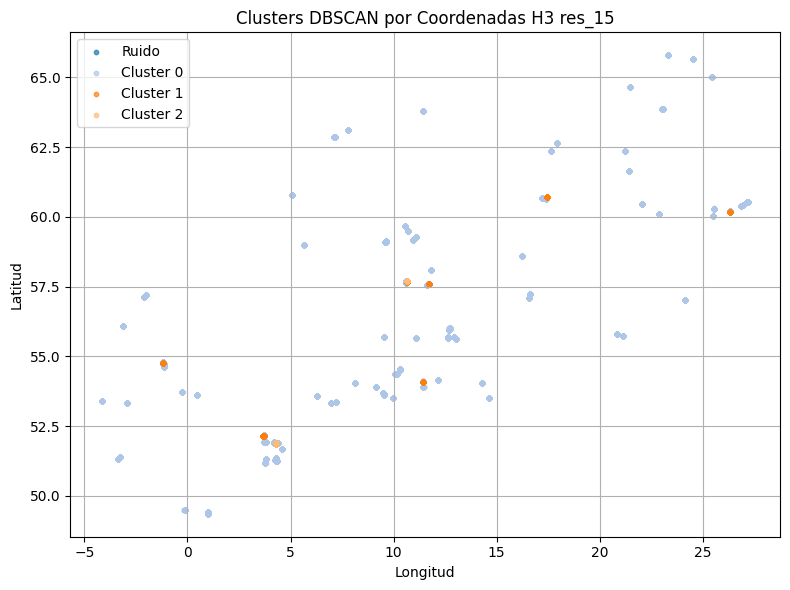

In [35]:


# Cargar los datos (si no están ya en memoria)
df_resultado = pd.read_csv("clusters_dbscan_result.csv")

# Crear la figura
plt.figure(figsize=(8, 6))

# Obtener los clusters únicos
clusters = sorted(df_resultado["cluster_label"].unique())

# Asignar colores
colormap = plt.get_cmap("tab20")

for i, cluster_id in enumerate(clusters):
    cluster_data = df_resultado[df_resultado["cluster_label"] == cluster_id]
    label = f"Cluster {cluster_id}" if cluster_id != -1 else "Ruido"
    plt.scatter(cluster_data["lon"], cluster_data["lat"],
                s=10, alpha=0.7,
                label=label,
                color=colormap(i % 20))  # Colores cíclicos

plt.title("Clusters DBSCAN por Coordenadas H3 res_15")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
import folium

m = folium.Map(location=[df_resultado["lat"].mean(), df_resultado["lon"].mean()], zoom_start=5)

for _, row in df_resultado.iterrows():
    color = "gray" if row["cluster_label"] == -1 else "orange"
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

m.save("clusters_map.html")

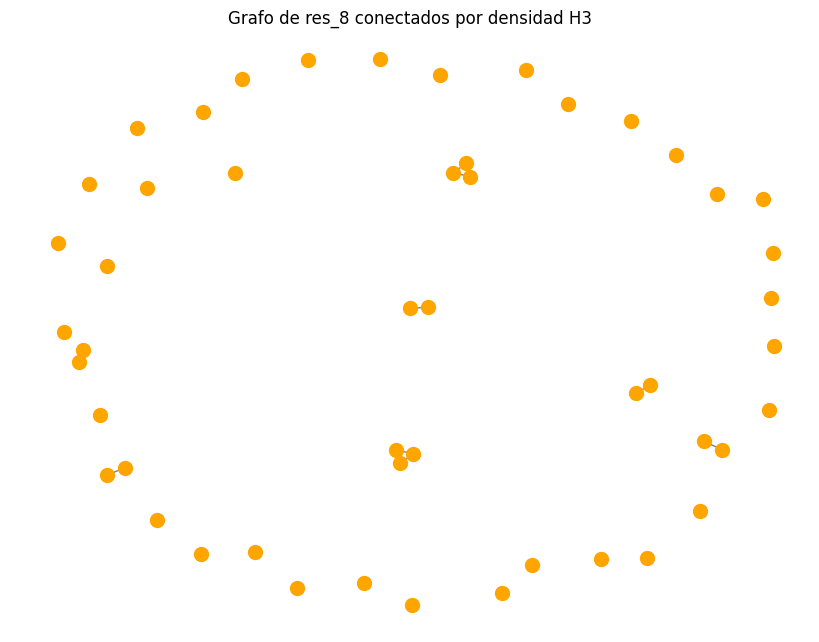

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

# Visualizar el grafo completo (subgrafo si es muy grande)
subgrafo = G.subgraph(list(G.nodes)[:50])  # ajustá a tu caso

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(subgrafo, seed=42)  # Layout estético
nx.draw(subgrafo, pos, with_labels=False, node_size=100, node_color="orange", edge_color="gray")
plt.title("Grafo de res_8 conectados por densidad H3")
plt.show()